# Microsoft Malware Challenge

## LightGBM - Tuning

## For CSCE 633 Machine Learning, Spring 2019, Course project
### Team: MARTHA
### Author: Rose Lin

This is the fourth notebook in the series. The lightGBM baseline model is good, but we would like to tune it for more informational gain.

~Ongoing efforts, your feedback is appreciated!~

## Initial setup

Loading data, packages, etc.

In [1]:
# load the data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt
#import json

import xgboost as xgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import gc
gc.enable()

In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
print('Loading Train and Test Data.\n')
train = pd.read_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/train.csv', dtype=dtypes, low_memory=True)
train['MachineIdentifier'] = train.index.astype('uint32')
#test  = pd.read_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/test.csv',  dtype=dtypes, low_memory=True)
#test['MachineIdentifier']  = test.index.astype('uint32')

gc.collect()

Loading Train and Test Data.



228760

In [0]:
print("Training size:",len(train))
print("Testing size:",len(test))

Training size: 8921483
Testing size: 7853253


In [0]:
train.head(n=2)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0


## Dropping features

Trying with the selected features in our EDA and also removing the original versioning features ("AvSigVersion", "EngineVersion", "AppVersion", "CensusOSBuildRevision", "CensusOSVersion") here ([source](https://www.kaggle.com/c/microsoft-malware-prediction/discussion/84112#latest-501154)).

1. Keeping only EDA features

In [0]:
train_cleaned = train[['MachineIdentifier','ProductName','EngineVersion','AppVersion','AvSigVersion','IsBeta','RtpStateBitfield','AVProductStatesIdentifier','AVProductsInstalled','AVProductsEnabled','HasTpm','CountryIdentifier','CityIdentifier','OrganizationIdentifier','GeoNameIdentifier','LocaleEnglishNameIdentifier','Processor','OsVer','OsBuild','OsSuite','OsPlatformSubRelease','OsBuildLab','IsProtected','AutoSampleOptIn','SMode','IeVerIdentifier','SmartScreen','Firewall','UacLuaenable','Census_MDC2FormFactor','Census_DeviceFamily','Census_OEMNameIdentifier','Census_OEMModelIdentifier','Census_ProcessorCoreCount','Census_ProcessorModelIdentifier','Census_PrimaryDiskTotalCapacity','Census_PrimaryDiskTypeName','Census_SystemVolumeTotalCapacity','Census_HasOpticalDiskDrive','Census_TotalPhysicalRAM','Census_ChassisTypeName','Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal','Census_PowerPlatformRoleName','Census_InternalBatteryNumberOfCharges','Census_OSVersion','Census_OSBranch','Census_OSBuildRevision','Census_OSEdition','Census_OSInstallTypeName','Census_OSInstallLanguageIdentifier','Census_OSWUAutoUpdateOptionsName','Census_IsPortableOperatingSystem','Census_GenuineStateName','Census_ActivationChannel','Census_IsFlightsDisabled','Census_FlightRing','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Census_IsSecureBootEnabled','Census_IsVirtualDevice','Census_IsTouchEnabled','Census_IsPenCapable','Census_IsAlwaysOnAlwaysConnectedCapable','Wdft_IsGamer','Wdft_RegionIdentifier','HasDetections']]
test_cleaned = test[['MachineIdentifier','ProductName','EngineVersion','AppVersion','AvSigVersion','IsBeta','RtpStateBitfield','AVProductStatesIdentifier','AVProductsInstalled','AVProductsEnabled','HasTpm','CountryIdentifier','CityIdentifier','OrganizationIdentifier','GeoNameIdentifier','LocaleEnglishNameIdentifier','Processor','OsVer','OsBuild','OsSuite','OsPlatformSubRelease','OsBuildLab','IsProtected','AutoSampleOptIn','SMode','IeVerIdentifier','SmartScreen','Firewall','UacLuaenable','Census_MDC2FormFactor','Census_DeviceFamily','Census_OEMNameIdentifier','Census_OEMModelIdentifier','Census_ProcessorCoreCount','Census_ProcessorModelIdentifier','Census_PrimaryDiskTotalCapacity','Census_PrimaryDiskTypeName','Census_SystemVolumeTotalCapacity','Census_HasOpticalDiskDrive','Census_TotalPhysicalRAM','Census_ChassisTypeName','Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal','Census_PowerPlatformRoleName','Census_InternalBatteryNumberOfCharges','Census_OSVersion','Census_OSBranch','Census_OSBuildRevision','Census_OSEdition','Census_OSInstallTypeName','Census_OSInstallLanguageIdentifier','Census_OSWUAutoUpdateOptionsName','Census_IsPortableOperatingSystem','Census_GenuineStateName','Census_ActivationChannel','Census_IsFlightsDisabled','Census_FlightRing','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Census_IsSecureBootEnabled','Census_IsVirtualDevice','Census_IsTouchEnabled','Census_IsPenCapable','Census_IsAlwaysOnAlwaysConnectedCapable','Wdft_IsGamer','Wdft_RegionIdentifier']]

In [0]:
del train, test
gc.collect()

112

In [0]:
print('Transforming partial features to category.\n')
counter = 0

for usecol in train_cleaned.columns.tolist()[1:-1]:

    train_cleaned[usecol] = train_cleaned[usecol].astype('str')
    test_cleaned[usecol] = test_cleaned[usecol].astype('str')
    
    if counter % 5 == 0:
        print("Transformed",counter,"features.")
    
    train_cleaned[usecol] = train_cleaned[usecol].astype('str')
    test_cleaned[usecol] = test_cleaned[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train_cleaned[usecol].unique().tolist()+
                      test_cleaned[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train_cleaned[usecol] = le.transform(train_cleaned[usecol])+1
    test_cleaned[usecol]  = le.transform(test_cleaned[usecol])+1

    agg_tr = (train_cleaned
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    agg_te = (test_cleaned
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]

    train_cleaned[usecol] = (pd.merge(train_cleaned[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test_cleaned[usecol]  = (pd.merge(test_cleaned[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()
    
    counter += 1

Transforming partial features to category.

Transformed 0 features.
Transformed 5 features.
Transformed 10 features.
Transformed 15 features.
Transformed 20 features.
Transformed 25 features.
Transformed 30 features.
Transformed 35 features.
Transformed 40 features.
Transformed 45 features.
Transformed 50 features.
Transformed 55 features.
Transformed 60 features.


In [0]:
print("New training size:",len(train_cleaned))
print("New testing size:",len(test_cleaned))

New training size: 8921483
New testing size: 7853253


In [0]:
y_train = np.array(train_cleaned['HasDetections'])
train_ids = train_cleaned.index
test_ids  = test_cleaned.index

del train_cleaned['HasDetections'], train_cleaned['MachineIdentifier'], test_cleaned['MachineIdentifier']
gc.collect()

21

In [0]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train_cleaned)

#Transform data using small groups to reduce memory usage
m = 100000
train_cleaned = vstack([ohe.transform(train_cleaned[i*m:(i+1)*m]) for i in range(train_cleaned.shape[0] // m + 1)])
test_cleaned  = vstack([ohe.transform(test_cleaned[i*m:(i+1)*m])  for i in range(test_cleaned.shape[0] // m + 1)])

save_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/train_EDA.npz', train_cleaned, compressed=True)
save_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/test_EDA.npz',  test_cleaned,  compressed=True)

del ohe, train_cleaned, test_cleaned
gc.collect()

924

All we need is just the *y_train*, *train_ids* and *test_ids*. To free up memory the original dataframes can be removed.

In [0]:
# skip this line of code if you have not run one hot encoding before
del train_cleaned, test_cleaned
gc.collect()

In [0]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
#test_ids  = test.index

del train
gc.collect()

210

In [0]:
from datetime import datetime

now = datetime.now() # current date and time
today_string = now.strftime("%m-%d-%Y")
print("Today's string:",today_string)

Today's string: 04-17-2019


In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

counter = 0
m = 100000

print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    train = load_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/train_EDA.npz')
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    del train
    gc.collect()
    
    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.1,
                                   colsample_bytree=0.28,
                                   objective='binary',
                                   random_state=37,
                                   n_jobs=-1)
                              
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    print('\nPlotting metrics recorded during training...')
    ax = lgb_model.plot_metric(evals_result, metric='auc')
    plt.show()
    
    print("\nDumping out the model persistence as pickles.")
    # dump model with pickle
    with open('/content/gdrive/My Drive/Coding experiment/MARTHA/Models/Checkpoints/lightgbm_EDA_'+today_string+'_'+str(counter)+'.pkl', 'wb') as fout:
        pickle.dump(lgb_model, fout)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    counter += 1


LightGBM

Fold 1

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.620187	valid_0's auc: 0.708097
[200]	valid_0's binary_logloss: 0.615333	valid_0's auc: 0.714394
[300]	valid_0's binary_logloss: 0.613021	valid_0's auc: 0.717609
[400]	valid_0's binary_logloss: 0.611543	valid_0's auc: 0.719647
[500]	valid_0's binary_logloss: 0.610554	valid_0's auc: 0.720993
[600]	valid_0's binary_logloss: 0.609695	valid_0's auc: 0.722138
[700]	valid_0's binary_logloss: 0.608989	valid_0's auc: 0.723092
[800]	valid_0's binary_logloss: 0.608452	valid_0's auc: 0.723823
[900]	valid_0's binary_logloss: 0.608022	valid_0's auc: 0.724396
[1000]	valid_0's binary_logloss: 0.607512	valid_0's auc: 0.725081
[1100]	valid_0's binary_logloss: 0.607279	valid_0's auc: 0.725393
[1200]	valid_0's binary_logloss: 0.606981	valid_0's auc: 0.725789
[1300]	valid_0's binary_logloss: 0.606727	valid_0's auc: 0.726123
[1400]	valid_0's binary_logloss: 0.606448	valid_0's auc: 0.726469
[15

AttributeError: ignored

Looks like using EDA features do not help here (AUC is not as good as the baseline even after 5000+ iterations)

2. Remove the version features

In [0]:
train_cleaned = train.drop(columns=["AvSigVersion", "EngineVersion", "AppVersion", "Census_OSBuildRevision", "Census_OSVersion"])
test_cleaned = test.drop(columns=["AvSigVersion", "EngineVersion", "AppVersion", "Census_OSBuildRevision", "Census_OSVersion"])

In [6]:
del train, test
gc.collect()

70

In [7]:
print('Transforming partial features to category.\n')
counter = 0

for usecol in train_cleaned.columns.tolist()[1:-1]:

    train_cleaned[usecol] = train_cleaned[usecol].astype('str')
    test_cleaned[usecol] = test_cleaned[usecol].astype('str')
    
    if counter % 5 == 0:
        print("Transformed",counter,"features.")
    
    train_cleaned[usecol] = train_cleaned[usecol].astype('str')
    test_cleaned[usecol] = test_cleaned[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train_cleaned[usecol].unique().tolist()+
                      test_cleaned[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train_cleaned[usecol] = le.transform(train_cleaned[usecol])+1
    test_cleaned[usecol]  = le.transform(test_cleaned[usecol])+1

    agg_tr = (train_cleaned
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    agg_te = (test_cleaned
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]

    train_cleaned[usecol] = (pd.merge(train_cleaned[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test_cleaned[usecol]  = (pd.merge(test_cleaned[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()
    
    counter += 1

Transforming partial features to category.

Transformed 0 features.
Transformed 5 features.
Transformed 10 features.
Transformed 15 features.
Transformed 20 features.
Transformed 25 features.
Transformed 30 features.
Transformed 35 features.
Transformed 40 features.
Transformed 45 features.
Transformed 50 features.
Transformed 55 features.
Transformed 60 features.
Transformed 65 features.
Transformed 70 features.
Transformed 75 features.


In [0]:
print("New training size:",len(train_cleaned))
print("New testing size:",len(test_cleaned))

New training size: 8921483
New testing size: 7853253


In [0]:
y_train = np.array(train_cleaned['HasDetections'])
train_ids = train_cleaned.index
test_ids  = test_cleaned.index

del train_cleaned['HasDetections'], train_cleaned['MachineIdentifier'], test_cleaned['MachineIdentifier']
gc.collect()

In [9]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train_cleaned)

#Transform data using small groups to reduce memory usage
m = 100000
train_cleaned = vstack([ohe.transform(train_cleaned[i*m:(i+1)*m]) for i in range(train_cleaned.shape[0] // m + 1)])
test_cleaned  = vstack([ohe.transform(test_cleaned[i*m:(i+1)*m])  for i in range(test_cleaned.shape[0] // m + 1)])

save_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/train_nover.npz', train_cleaned, compressed=True)
save_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/test_nover.npz',  test_cleaned,  compressed=True)

del ohe, train_cleaned, test_cleaned
gc.collect()

1078

All we need is just the *y_train*, *train_ids* and *test_ids*. To free up memory the original dataframes can be removed.

In [0]:
# skip this line of code if you have not run one hot encoding before
del train_cleaned, test_cleaned
gc.collect()

In [7]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
#test_ids  = test.index

del train
gc.collect()

134

In [8]:
from datetime import datetime

now = datetime.now() # current date and time
today_string = now.strftime("%m-%d-%Y")
print("Today's string:",today_string)

Today's string: 04-19-2019



LightGBM

Fold 1

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.617317	valid_0's auc: 0.71087
[200]	valid_0's binary_logloss: 0.614633	valid_0's auc: 0.71473
[300]	valid_0's binary_logloss: 0.613657	valid_0's auc: 0.716148
[400]	valid_0's binary_logloss: 0.612711	valid_0's auc: 0.717365
[500]	valid_0's binary_logloss: 0.612342	valid_0's auc: 0.717854
[600]	valid_0's binary_logloss: 0.611982	valid_0's auc: 0.718361
[700]	valid_0's binary_logloss: 0.611847	valid_0's auc: 0.718562
[800]	valid_0's binary_logloss: 0.611729	valid_0's auc: 0.718726
Early stopping, best iteration is:
[785]	valid_0's binary_logloss: 0.611717	valid_0's auc: 0.718742

Plotting metrics recorded during training...


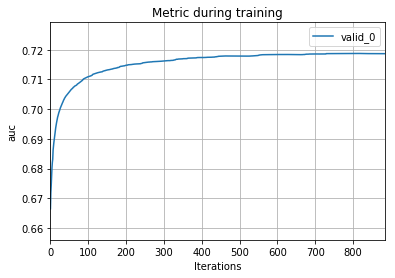


Dumping out the model persistence as pickles.
Fold 2

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.617562	valid_0's auc: 0.711033
[200]	valid_0's binary_logloss: 0.614975	valid_0's auc: 0.714744
[300]	valid_0's binary_logloss: 0.613595	valid_0's auc: 0.71662
[400]	valid_0's binary_logloss: 0.613107	valid_0's auc: 0.717256
[500]	valid_0's binary_logloss: 0.612395	valid_0's auc: 0.718228
Early stopping, best iteration is:
[487]	valid_0's binary_logloss: 0.612375	valid_0's auc: 0.718253

Plotting metrics recorded during training...


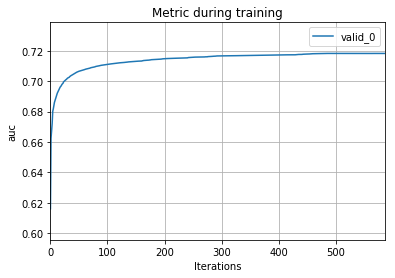


Dumping out the model persistence as pickles.
Fold 3

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.617517	valid_0's auc: 0.710885
[200]	valid_0's binary_logloss: 0.614873	valid_0's auc: 0.714706
[300]	valid_0's binary_logloss: 0.613676	valid_0's auc: 0.716419
[400]	valid_0's binary_logloss: 0.61327	valid_0's auc: 0.716937
[500]	valid_0's binary_logloss: 0.613108	valid_0's auc: 0.717147
[600]	valid_0's binary_logloss: 0.613035	valid_0's auc: 0.717235
[700]	valid_0's binary_logloss: 0.612435	valid_0's auc: 0.718012
[800]	valid_0's binary_logloss: 0.612296	valid_0's auc: 0.718197
[900]	valid_0's binary_logloss: 0.61221	valid_0's auc: 0.718346
Early stopping, best iteration is:
[861]	valid_0's binary_logloss: 0.61219	valid_0's auc: 0.718357

Plotting metrics recorded during training...


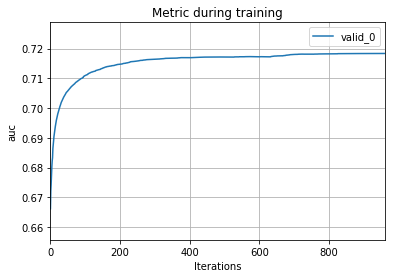


Dumping out the model persistence as pickles.
Fold 4

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.616672	valid_0's auc: 0.711939
[200]	valid_0's binary_logloss: 0.613983	valid_0's auc: 0.715737
[300]	valid_0's binary_logloss: 0.612913	valid_0's auc: 0.717205
[400]	valid_0's binary_logloss: 0.612208	valid_0's auc: 0.718184
[500]	valid_0's binary_logloss: 0.61188	valid_0's auc: 0.71861
[600]	valid_0's binary_logloss: 0.611717	valid_0's auc: 0.718776
[700]	valid_0's binary_logloss: 0.611515	valid_0's auc: 0.719
[800]	valid_0's binary_logloss: 0.611399	valid_0's auc: 0.719186
[900]	valid_0's binary_logloss: 0.611437	valid_0's auc: 0.719161
Early stopping, best iteration is:
[815]	valid_0's binary_logloss: 0.611375	valid_0's auc: 0.719215

Plotting metrics recorded during training...


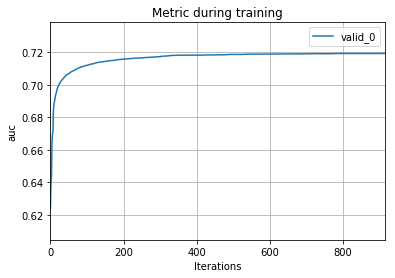


Dumping out the model persistence as pickles.
Fold 5

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.6173	valid_0's auc: 0.71106
[200]	valid_0's binary_logloss: 0.614384	valid_0's auc: 0.715151
[300]	valid_0's binary_logloss: 0.613507	valid_0's auc: 0.716388
[400]	valid_0's binary_logloss: 0.613198	valid_0's auc: 0.716839
[500]	valid_0's binary_logloss: 0.612486	valid_0's auc: 0.717821
[600]	valid_0's binary_logloss: 0.612157	valid_0's auc: 0.71823
[700]	valid_0's binary_logloss: 0.61215	valid_0's auc: 0.718265
[800]	valid_0's binary_logloss: 0.611803	valid_0's auc: 0.718738
[900]	valid_0's binary_logloss: 0.611875	valid_0's auc: 0.718652
[1000]	valid_0's binary_logloss: 0.611623	valid_0's auc: 0.718985
Early stopping, best iteration is:
[958]	valid_0's binary_logloss: 0.611627	valid_0's auc: 0.718997

Plotting metrics recorded during training...


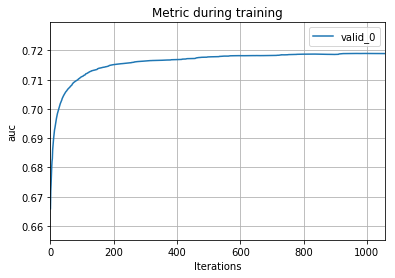


Dumping out the model persistence as pickles.


In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

counter = 0
m = 100000

print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    train = load_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/train_nover.npz')
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    del train
    gc.collect()
    
    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.5,
                                   colsample_bytree=0.28,
                                   objective='binary',
                                   random_state=37,
                                   n_jobs=-1)
                              
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    print('\nPlotting metrics recorded during training...')
    ax = lgb.plot_metric(lgb_model.evals_result_, metric='auc')
    plt.show()
    
    print("\nDumping out the model persistence as pickles.")
    # dump model with pickle
    with open('/content/gdrive/My Drive/Coding experiment/MARTHA/Models/Checkpoints/lightgbm_nover_'+today_string+'_'+str(counter)+'.pkl', 'wb') as fout:
        pickle.dump(lgb_model, fout)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    counter += 1

## Generating predictions

Now the fun part begins! (Assuming that the test data has been transformed and saved already.)

In [0]:
test = load_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/test_nover.npz')
test = csr_matrix(test, dtype='float32')

In [0]:
submission = pd.read_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/sample_submission.csv')
lgb_test_result_1  = np.zeros(submission['MachineIdentifier'].shape[0])

In [5]:
from os import listdir
from os.path import isfile, join

folder_path = '/content/gdrive/My Drive/Coding experiment/MARTHA/Models/cp2/'

print("\nLightGBM - Prediction\n")

for f in listdir(folder_path):
  print("Loading saved model pickle file:",f)
  saved_model_path = join(folder_path,f)
  
  with open(saved_model_path, 'rb') as fin:
    lgb_model = pickle.load(fin)
  lgb_test_result_1 += lgb_model.predict_proba(test)[:,1]
  print("Result saved.\n")
  
  del lgb_model
  gc.collect()


LightGBM - Prediction

Loading saved model pickle file: lightgbm_nover_04-19-2019_0.pkl
Result saved.

Loading saved model pickle file: lightgbm_nover_04-19-2019_1.pkl
Result saved.

Loading saved model pickle file: lightgbm_nover_04-19-2019_2.pkl
Result saved.

Loading saved model pickle file: lightgbm_nover_04-19-2019_3.pkl
Result saved.

Loading saved model pickle file: lightgbm_nover_04-19-2019_4.pkl
Result saved.



In [0]:
# divided by 5 coz there are 5 models.
submission['HasDetections'] = lgb_test_result_1 / 5
submission.to_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/lgb_nover_submission.csv', index=False)